In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import norm, skew
from sklearn.preprocessing import OneHotEncoder

In [2]:
data = pd.read_csv("train.csv", sep=",")
X_t = pd.read_csv("test.csv", sep=",")
print(data.shape, X_t.shape)
data.head(5)

(1460, 81) (1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
#Смотрим, где у нас отсутствуют данные
t = data.isnull().sum()
t[t>0]

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64

In [4]:
#Делим данные на целевую переменную и фичи, и смотрим целевую переменную
X = data.drop(['SalePrice','Id'], axis = 1)
id_test = X_t['Id']
X_t = X_t.drop(['Id'], axis = 1)
y = data['SalePrice']
y.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

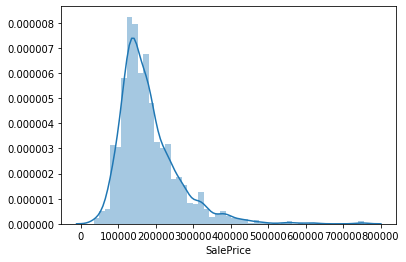

In [5]:
sns.distplot(y)

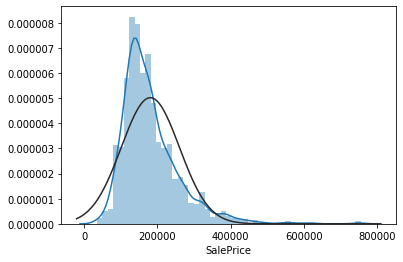

In [6]:
#Нормализуем Y и строим новый график
y_log = np.log(y)
sns.distplot(y, fit = norm)

In [7]:
replacements = {
    'PoolQC':{'map':{'Gd': 3, 'Ex': 4, 'Fa': 1, 'Ta': 2}, 'FillNA': 0},
    'Fence':{'map':{'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1}, 'FillNA': 0},
    'FireplaceQu':{'map':{'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}, 'FillNA': 0},
    'Electrical':{'FillNA': 'SBrkr'},
    'BsmtQual':{'map':{'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},'FillNA': 0},
    'BsmtCond':{'map':{'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},'FillNA': 0},
    'MasVnrType':{'map':{'None': 'NA'}, 'FillNA': 'NA'},
    'GarageYrBlt':{'FillNA': 1800},
}



In [8]:
def replace(df):
    res = pd.DataFrame()
    for c in df.columns:
        #print(c)
        if c in replacements.keys():
            if 'map' in replacements[c]:
                res[c] = df[c].map(replacements[c]['map']).fillna(replacements[c]['FillNA'])
            else:
                res[c] = df[c].fillna(replacements[c]['FillNA'])
        else:
            if df.dtypes[c] == 'object':
                res[c] = df[c].fillna('NA')
            else:
                res[c] = df[c].fillna(0)
                
    res['Pool'] = res['PoolQC'] > 0
    res['Garage'] = res['GarageType']!= 'NA'
    return res

In [9]:
X = replace(X)
print(X.head(), X.isnull().sum().sum())
print(X['Fence'].value_counts())

   MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0          60       RL         65.0     8450   Pave    NA      Reg   
1          20       RL         80.0     9600   Pave    NA      Reg   
2          60       RL         68.0    11250   Pave    NA      IR1   
3          70       RL         60.0     9550   Pave    NA      IR1   
4          60       RL         84.0    14260   Pave    NA      IR1   

  LandContour Utilities LotConfig  ... PoolQC Fence MiscFeature MiscVal  \
0         Lvl    AllPub    Inside  ...    0.0   0.0          NA       0   
1         Lvl    AllPub       FR2  ...    0.0   0.0          NA       0   
2         Lvl    AllPub    Inside  ...    0.0   0.0          NA       0   
3         Lvl    AllPub    Corner  ...    0.0   0.0          NA       0   
4         Lvl    AllPub       FR2  ...    0.0   0.0          NA       0   

  MoSold YrSold  SaleType  SaleCondition   Pool  Garage  
0      2   2008        WD         Normal  False    True  
1      5   2

In [10]:
X_t = replace(X_t)
print(X_t.isnull().sum().sum())
print(X_t['Fence'].value_counts())

0
0.0    1169
3.0     172
4.0      59
2.0      58
1.0       1
Name: Fence, dtype: int64


In [11]:
#Ищем колонки с категориальными фичами
t = X.dtypes
categ = t[t == 'object'].index
#t.value_counts()
c = X[categ]
c.shape
c.head(10)

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,NA,WD,Normal
1,RL,Pave,NA,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,TA,Typ,Attchd,RFn,TA,TA,Y,NA,WD,Normal
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,NA,WD,Normal
3,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Gd,Typ,Detchd,Unf,TA,TA,Y,NA,WD,Abnorml
4,RL,Pave,NA,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,NA,WD,Normal
5,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,...,TA,Typ,Attchd,Unf,TA,TA,Y,Shed,WD,Normal
6,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,NA,WD,Normal
7,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,...,TA,Typ,Attchd,RFn,TA,TA,Y,Shed,WD,Normal
8,RM,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,...,TA,Min1,Detchd,Unf,Fa,TA,Y,NA,WD,Abnorml
9,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,BrkSide,Artery,...,TA,Typ,Attchd,RFn,Gd,TA,Y,NA,WD,Normal


In [12]:
#И повторяем для теста
c_test = X_t[categ]
print(c_test.shape)
c_test.head(10)

(1459, 38)


,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,MiscFeature,SaleType,SaleCondition
0,RH,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,...,TA,Typ,Attchd,Unf,TA,TA,Y,NA,WD,Normal
1,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,Gd,Typ,Attchd,Unf,TA,TA,Y,Gar2,WD,Normal
2,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,TA,Typ,Attchd,Fin,TA,TA,Y,NA,WD,Normal
3,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Gd,Typ,Attchd,Fin,TA,TA,Y,NA,WD,Normal
4,RL,Pave,NA,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,NA,WD,Normal
5,RL,Pave,NA,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,...,TA,Typ,Attchd,Fin,TA,TA,Y,NA,WD,Normal
6,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,TA,Typ,Attchd,Fin,TA,TA,Y,Shed,WD,Normal
7,RL,Pave,NA,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,TA,Typ,Attchd,Fin,TA,TA,Y,NA,WD,Normal
8,RL,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Gd,Typ,Attchd,Unf,TA,TA,Y,NA,WD,Normal
9,RL,Pave,NA,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,...,TA,Typ,Attchd,Fin,TA,TA,Y,NA,WD,Normal


In [13]:
categ

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'GarageType',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

In [14]:
#Преобразовываем категориальные фичи
ohe = OneHotEncoder(sparse = False, categories = 'auto', handle_unknown = 'ignore')
c2 = ohe.fit_transform(c)
ohe.get_feature_names()
c3 = pd.DataFrame(c2, index = c.index, columns = ohe.get_feature_names())
c3.head()
X = pd.concat([X.drop(c.columns, axis = 1),c3], axis = 1)
X.shape


(1460, 281)

In [15]:
print(X['Fence'].value_counts())

0.0    1179
3.0     157
4.0      59
2.0      54
1.0      11
Name: Fence, dtype: int64


In [16]:
c2_test = ohe.transform(c_test)
c3_test = pd.DataFrame(c2_test, index = c_test.index, columns = ohe.get_feature_names())
c3_test.head()
X_t = pd.concat([X_t.drop(c.columns, axis = 1),c3_test], axis = 1)
X_t.shape

(1459, 281)

In [17]:
print(X_t['Fence'].value_counts())

0.0    1169
3.0     172
4.0      59
2.0      58
1.0       1
Name: Fence, dtype: int64


In [18]:
#Ну что, фичи как-то упорядочили... Понеслааась
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

In [19]:
X_train, X_test, y_train_orig, y_test_orig = train_test_split(X, np.array(y))

In [20]:
y_train = np.log(y_train_orig)
y_test = np.log(y_test_orig)

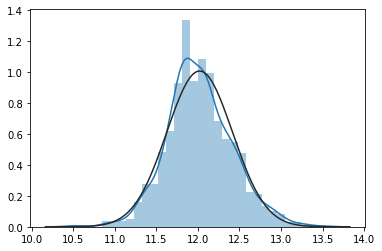

In [21]:
sns.distplot(y_train, fit = norm)

In [22]:
scaler = RobustScaler()
scaler.fit(X_train)

RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
             with_scaling=True)

In [23]:
X_train.dtypes

MSSubClass       int64
LotFrontage    float64
LotArea          int64
OverallQual      int64
OverallCond      int64
                ...   
x37_AdjLand    float64
x37_Alloca     float64
x37_Family     float64
x37_Normal     float64
x37_Partial    float64
Length: 281, dtype: object

In [24]:
t = X_train.dtypes
print(t[t == 'object'])
t1 = X_t.dtypes
print(t1[t1 == 'object'])

Series([], dtype: object)
Series([], dtype: object)


In [25]:
regressor = Lasso()
regressor.fit(scaler.transform(X_train), y_train)
y_pred = regressor.predict(scaler.transform(X_test))
t = (mean_squared_error(np.exp(y_pred), y_test_orig))
print(t, np.sqrt(t))
t2 = mean_squared_error(y_pred, y_test)
print(t2, np.exp(t2))


6595431014.851068 81212.25901827302
0.16579956750859945 1.180336500227323


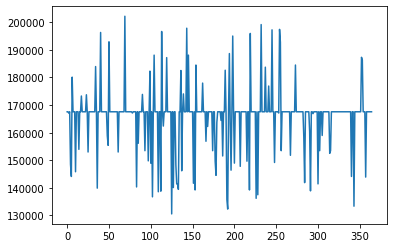

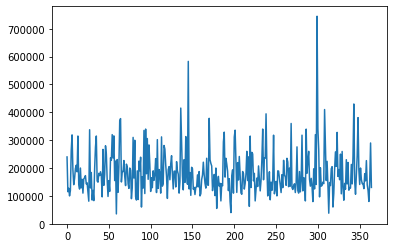

In [26]:
plt.clf()
plt.plot(np.exp(y_pred))
plt.show()
plt.clf()
plt.plot(y_test_orig)
plt.show()

In [27]:
est = [145] #range(100, 200, 5)
m_s = [2]#, 3, 4]
regressor = RandomForestRegressor(random_state=0)
grid = {'n_estimators': est, 'min_samples_split': m_s}
gs = GridSearchCV(regressor, grid, scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 10 )
gs.fit(scaler.fit_transform(X_train), y_train)
y_pred = gs.predict(scaler.transform(X_test))
t = mean_squared_error(y_test, y_pred)
print(t, np.exp(t))
gs.best_params_

C:\Users\Lesika\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.6s finished


0.024992451072029995 1.025307380523652


{'min_samples_split': 2, 'n_estimators': 145}

In [30]:
y_test_pred = gs.predict(scaler.transform(X_t))
print(y_test_pred[0:10], np.exp(y_test_pred)[:10], np.exp(y_test_pred.mean()))

[11.72066564 11.91983299 12.06157828 12.09135665 12.15934072 12.11613869
 11.97886567 12.07965016 12.13643087 11.70347129] [123089.33059719 150216.51881716 173091.95810201 178323.86574621
 190868.63872507 182798.30863665 159351.17112554 176248.49044059
 186545.57629457 120990.9810771 ] 164458.2165971866


In [32]:
# готовим файл для сабмита на Каггл
my_submission = pd.DataFrame({'Id': id_test, 'SalePrice': np.exp(y_test_pred)})
my_submission.to_csv('submission.csv', index=False)